# Подход к решению
Возможные подходы:
1. Разбить слова на слоги по правилам русского языка.  Слово будет "текстом", слоги будут играть роль "слов". Дальше используем стандартные средства работы с текстом (векторизация и эмбеддинг слогов и т.п.).
2. Разбить слова на буквы, делать векторизацию букв. Алгоритм сам будет выявлять закономерности

В этой версии использую второй подход.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import chime

2023-03-31 20:56:11.079930: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 20:56:11.134574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 20:56:12.142813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext chime

In [3]:
df = pd.read_csv('train.csv', index_col='id'); df

,word,stress,num_syllables,lemma
id,,,,
0,румяной,2,3,румяный
1,цифрами,1,3,цифра
2,слугами,1,3,слуга
3,выбирает,3,4,выбирать
4,управдом,3,3,управдом
...,...,...,...,...
63433,экзамена,2,4,экзамен
63434,культурой,2,3,культура
63435,объемной,2,3,объемный


Для удобства сдвигаю нумерацию слогов, чтобы она начиналась с 0. Не забыть сдвинуть обратно окончательный прогноз!

In [4]:
df.stress = df.stress - 1

# Набор символов
Нахожу все используемые символы

In [5]:
def add_char(word):
    global alphabeth
    alphabeth = alphabeth.union(set(list(word)))

In [6]:
alphabeth = set()

In [7]:
df.word.apply(add_char)

id
0        None
1        None
2        None
3        None
4        None
         ... 
63433    None
63434    None
63435    None
63436    None
63437    None
Name: word, Length: 63438, dtype: object

In [8]:
df.lemma.apply(add_char)

id
0        None
1        None
2        None
3        None
4        None
         ... 
63433    None
63434    None
63435    None
63436    None
63437    None
Name: lemma, Length: 63438, dtype: object

In [9]:
alphabeth

{'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё'}

Нумерую буквы

In [10]:
numbers = list(range(1, len(alphabeth) + 1))

In [11]:
alphabeth = {k: v for k, v in zip(list(alphabeth), numbers)}; alphabeth

{'с': 1,
 'г': 2,
 'т': 3,
 'ы': 4,
 'ъ': 5,
 'п': 6,
 'л': 7,
 'м': 8,
 'к': 9,
 'д': 10,
 'ж': 11,
 'з': 12,
 'я': 13,
 'ф': 14,
 'ё': 15,
 'ш': 16,
 'ц': 17,
 'й': 18,
 'щ': 19,
 'н': 20,
 'б': 21,
 'е': 22,
 'э': 23,
 'х': 24,
 'у': 25,
 'ю': 26,
 'а': 27,
 'и': 28,
 'р': 29,
 'ч': 30,
 'ь': 31,
 'в': 32,
 'о': 33}

# Подготовка данных 

Число символов и слова отдельно, т.к. подаю на разные входы нейронной сети

In [12]:
y = df.stress
num_syllables = df.num_syllables
X = df.drop(columns=['stress', 'num_syllables'])

Разделяем на буквы

In [13]:
word = X.word.apply(lambda x: ' '.join(list(x)))
lemma = X.lemma.apply(lambda x: ' '.join(list(x)))

In [14]:
word = word.str.split(expand=True); word

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,р,у,м,я,н,о,й,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ц,и,ф,р,а,м,и,None,None,None,None,None,None,None,None,None,None,None,None,None
2,с,л,у,г,а,м,и,None,None,None,None,None,None,None,None,None,None,None,None,None
3,в,ы,б,и,р,а,е,т,None,None,None,None,None,None,None,None,None,None,None,None
4,у,п,р,а,в,д,о,м,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,э,к,з,а,м,е,н,а,None,None,None,None,None,None,None,None,None,None,None,None
63434,к,у,л,ь,т,у,р,о,й,None,None,None,None,None,None,None,None,None,None,None
63435,о,б,ъ,е,м,н,о,й,None,None,None,None,None,None,None,None,None,None,None,None


In [15]:
lemma = lemma.str.split(expand=True); lemma

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,р,у,м,я,н,ы,й,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ц,и,ф,р,а,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,с,л,у,г,а,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,в,ы,б,и,р,а,т,ь,None,None,None,None,None,None,None,None,None,None,None,None
4,у,п,р,а,в,д,о,м,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,э,к,з,а,м,е,н,None,None,None,None,None,None,None,None,None,None,None,None,None
63434,к,у,л,ь,т,у,р,а,None,None,None,None,None,None,None,None,None,None,None,None
63435,о,б,ъ,е,м,н,ы,й,None,None,None,None,None,None,None,None,None,None,None,None


Отсутсвующая буква в конце слова - 0. (Альтернативный вариант - ragged tensors.)

In [16]:
word.fillna(0, inplace=True)
lemma.fillna(0, inplace=True)

In [17]:
alphabeth[0] = 0

Заменяю буквы на номера

In [18]:
word = word.applymap(lambda x: alphabeth[x])
lemma = lemma.applymap(lambda x: alphabeth[x])

In [19]:
lemma

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,29,25,8,13,20,4,18,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,28,14,29,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,7,25,2,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,32,4,21,28,29,27,3,31,0,0,0,0,0,0,0,0,0,0,0,0
4,25,6,29,27,32,10,33,8,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,23,9,12,27,8,22,20,0,0,0,0,0,0,0,0,0,0,0,0,0
63434,9,25,7,31,3,25,29,27,0,0,0,0,0,0,0,0,0,0,0,0
63435,33,21,5,22,8,20,4,18,0,0,0,0,0,0,0,0,0,0,0,0


Объединяю

In [20]:
X = np.concatenate((word, lemma), axis=1)

In [21]:
X_train, X_val, y_train, y_val, num_syllables_train, num_syllables_val = train_test_split(
    X,
    y,
    num_syllables,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Модель

In [22]:
embedding_dim = 33

In [23]:
word_input = keras.Input(
    shape=(40),
    name='words_and_lemmas'
)
syll_input = keras.Input(
    shape=(1),
    name='num_syllables'
)

w = layers.Embedding(
    input_dim=34,
    output_dim=embedding_dim,
    mask_zero=True,
    input_length=40)(word_input)
w = layers.Bidirectional(layers.LSTM(units=40, dropout=0.1))(w)

s = layers.Dense(1, activation='relu')(syll_input)

x = layers.concatenate([w, s])
x = layers.Dense(40, activation='relu')(x)
x = layers.Dropout(0.1)(x)

pred = layers.Dense(6, activation='softmax')(x)

model = keras.Model(
    inputs = [word_input, syll_input],
    outputs = [pred]
)

2023-03-31 20:56:15.992107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-31 20:56:15.992140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: denis-Z68XP-UD3
2023-03-31 20:56:15.992150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: denis-Z68XP-UD3
2023-03-31 20:56:15.992228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 390.157.0
2023-03-31 20:56:15.992254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 390.157.0
2023-03-31 20:56:15.992264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 390.157.0


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words_and_lemmas (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 33)       1122        ['words_and_lemmas[0][0]']       
                                                                                                  
 num_syllables (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 80)           23680       ['embedding[0][0]']              
                                                                                              

In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics='accuracy')

In [26]:
%%time
%%chime
history=model.fit(
    {'words_and_lemmas': X_train,
    'num_syllables': num_syllables_train},
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.1
)

Epoch 1/100


2023-03-31 20:56:23.143299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-31 20:56:27.941126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


1428/1428 [==============================] - 43s 23ms/step - loss: 0.9219 - accuracy: 0.5842 - val_loss: 0.8058 - val_accuracy: 0.6467
Epoch 2/100
1428/1428 [==============================] - 29s 20ms/step - loss: 0.7856 - accuracy: 0.6605 - val_loss: 0.7494 - val_accuracy: 0.6814
Epoch 3/100
1428/1428 [==============================] - 29s 20ms/step - loss: 0.7420 - accuracy: 0.6837 - val_loss: 0.7018 - val_accuracy: 0.7021
Epoch 4/100
1428/1428 [==============================] - 29s 21ms/step - loss: 0.7038 - accuracy: 0.7039 - val_loss: 0.6765 - val_accuracy: 0.7182
Epoch 5/100
1428/1428 [==============================] - 29s 20ms/step - loss: 0.6746 - accuracy: 0.7169 - val_loss: 0.6399 - val_accuracy: 0.7346
Epoch 6/100
1428/1428 [==============================] - 29s 20ms/step - loss: 0.6424 - accuracy: 0.7333 - val_loss: 0.6143 - val_accuracy: 0.7431
Epoch 7/100
1428/1428 [==============================] - 29s 20ms/step - loss: 0.6203 - accuracy: 0.7454 - val_loss: 0.5835 - val_

1428/1428 [==============================] - 29s 21ms/step - loss: 0.2414 - accuracy: 0.9031 - val_loss: 0.3980 - val_accuracy: 0.8660
Epoch 57/100
1428/1428 [==============================] - 30s 21ms/step - loss: 0.2365 - accuracy: 0.9043 - val_loss: 0.3883 - val_accuracy: 0.8692
Epoch 58/100
1428/1428 [==============================] - 29s 21ms/step - loss: 0.2366 - accuracy: 0.9046 - val_loss: 0.3848 - val_accuracy: 0.8719
Epoch 59/100
1428/1428 [==============================] - 30s 21ms/step - loss: 0.2337 - accuracy: 0.9062 - val_loss: 0.3981 - val_accuracy: 0.8686
Epoch 60/100
1428/1428 [==============================] - 30s 21ms/step - loss: 0.2327 - accuracy: 0.9063 - val_loss: 0.3899 - val_accuracy: 0.8668
Epoch 61/100
1428/1428 [==============================] - 30s 21ms/step - loss: 0.2335 - accuracy: 0.9061 - val_loss: 0.3905 - val_accuracy: 0.8644
Epoch 62/100
1428/1428 [==============================] - 30s 21ms/step - loss: 0.2294 - accuracy: 0.9071 - val_loss: 0.3963 

In [27]:
history_pd = pd.DataFrame(history.history)

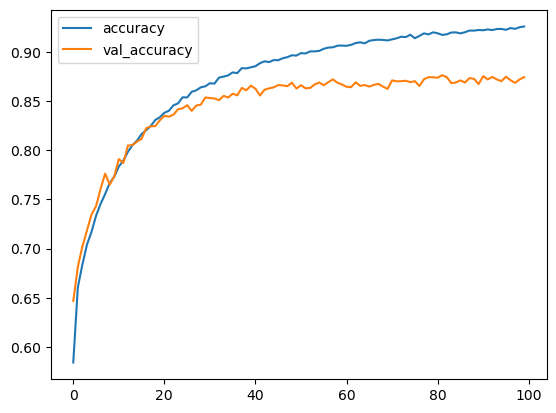

In [28]:
history_pd[['accuracy', 'val_accuracy']].plot.line();

In [29]:
y_val_pred = model.predict({'words_and_lemmas': X_val,
    'num_syllables': num_syllables_val})

397/397 [==============================] - 6s 6ms/step


In [30]:
accuracy_score(y_val, y_val_pred.argmax(axis=1))

0.8791771752837326

Проверка на разумность: номер предсказанного ударного слога не должен быть больше числа слогов в слове.

In [31]:
(y_val_pred.argmax(axis=1) > num_syllables_val).sum()

0

# Прогноз на тестовой выборке 

## Подготовка данных 

In [32]:
test = pd.read_csv('test.csv', index_col='id'); test

,word,num_syllables,lemma
id,,,
0,эпилепсия,5,эпилепсия
1,относящейся,5,относиться
2,размышлениями,6,размышление
3,модемы,3,модем
4,солнц,1,солнце
...,...,...,...
29955,донбасса,3,донбасс
29956,обложка,3,обложка
29957,правителя,4,правитель


Число символов и слова отдельно, т.к. подаю на разные входы нейронной сети

In [33]:
num_syllables_test = test.num_syllables
X_test = test.drop(columns=['num_syllables'])

Разделяем на буквы

In [34]:
word_test = X_test.word.apply(lambda x: ' '.join(list(x)))
lemma_test = X_test.lemma.apply(lambda x: ' '.join(list(x)))

In [35]:
word_test = word_test.str.split(expand=True); word_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,э,п,и,л,е,п,с,и,я,None,None,None,None,None,None,None,None,None,None
1,о,т,н,о,с,я,щ,е,й,с,я,None,None,None,None,None,None,None,None
2,р,а,з,м,ы,ш,л,е,н,и,я,м,и,None,None,None,None,None,None
3,м,о,д,е,м,ы,None,None,None,None,None,None,None,None,None,None,None,None,None
4,с,о,л,н,ц,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,д,о,н,б,а,с,с,а,None,None,None,None,None,None,None,None,None,None,None
29956,о,б,л,о,ж,к,а,None,None,None,None,None,None,None,None,None,None,None,None
29957,п,р,а,в,и,т,е,л,я,None,None,None,None,None,None,None,None,None,None


In [36]:
lemma_test = lemma_test.str.split(expand=True); lemma_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,э,п,и,л,е,п,с,и,я,None,None,None,None,None,None,None,None,None,None
1,о,т,н,о,с,и,т,ь,с,я,None,None,None,None,None,None,None,None,None
2,р,а,з,м,ы,ш,л,е,н,и,е,None,None,None,None,None,None,None,None
3,м,о,д,е,м,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,с,о,л,н,ц,е,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,д,о,н,б,а,с,с,None,None,None,None,None,None,None,None,None,None,None,None
29956,о,б,л,о,ж,к,а,None,None,None,None,None,None,None,None,None,None,None,None
29957,п,р,а,в,и,т,е,л,ь,None,None,None,None,None,None,None,None,None,None


Отсутсвующая буква в конце слова - 0. (Альтернативный вариант - ragged tensors.)

In [37]:
word_test.fillna(0, inplace=True)
lemma_test.fillna(0, inplace=True)

Заменяю буквы на номера

In [38]:
word_test = word_test.applymap(lambda x: alphabeth[x])
lemma_test = lemma_test.applymap(lambda x: alphabeth[x])

In [39]:
lemma_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,23,6,28,7,22,6,1,28,13,0,0,0,0,0,0,0,0,0,0
1,33,3,20,33,1,28,3,31,1,13,0,0,0,0,0,0,0,0,0
2,29,27,12,8,4,16,7,22,20,28,22,0,0,0,0,0,0,0,0
3,8,33,10,22,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,33,7,20,17,22,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,10,33,20,21,27,1,1,0,0,0,0,0,0,0,0,0,0,0,0
29956,33,21,7,33,11,9,27,0,0,0,0,0,0,0,0,0,0,0,0
29957,6,29,27,32,28,3,22,7,31,0,0,0,0,0,0,0,0,0,0


Объединяю

In [40]:
X_test = np.concatenate((word_test, lemma_test), axis=1); X_test

array([[23,  6, 28, ...,  0,  0,  0],
       [33,  3, 20, ...,  0,  0,  0],
       [29, 27, 12, ...,  0,  0,  0],
       ...,
       [ 6, 29, 27, ...,  0,  0,  0],
       [16, 22, 29, ...,  0,  0,  0],
       [33,  6,  3, ...,  0,  0,  0]])

## Прогноз 

In [41]:
y_test_pred = model.predict({'words_and_lemmas': X_test,
    'num_syllables': num_syllables_test})

937/937 [==============================] - 9s 6ms/step


In [42]:
y_test_pred = y_test_pred.argmax(axis=1)

In [43]:
(y_test_pred > num_syllables_test).sum()

1

In [44]:
submission = pd.DataFrame(data=y_test_pred, index=test.index, columns=['stress'])
submission.stress = submission.stress + 1
submission

,stress
id,
0,3
1,3
2,3
3,2
4,1
...,...
29955,2
29956,2
29957,2


In [45]:
submission.to_csv('submission_05.csv')